<a href="https://colab.research.google.com/github/TeradaZenichi/dgm-2023.2/blob/main/projetos/PVGEN/Code/Normalizing-Flow-Model/Notebook_Normalizing_Flow_PV_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [ ]:
%cd /content
!git clone https://github.com/TeradaZenichi/dgm-2023.2/
%cd /content/dgm-2023.2/projetos/PVGEN/notebooks/
!pip install -r requirements-colab.txt
%cd /content/dgm-2023.2/projetos/PVGEN/src/

# Execute 1-training.py
Train and Evaluate all at once in one script

In [4]:
!python 1-training.py

28272
1178
Indices where PV is always 0: [ 0  1  2  3  4  5 21 22 23]
First day:
                        POWER  Wind 2m (m/s)  ...      zenith     azimuth
2019-05-05 00:00:00  0.000000          0.000  ...  173.223026  190.337513
2019-05-05 01:00:00  0.000000          0.000  ...  165.449589  114.784731
2019-05-05 02:00:00  0.000000          0.000  ...  152.157490   98.606808
2019-05-05 03:00:00  0.000000          0.000  ...  138.387333   91.054346
2019-05-05 04:00:00  0.000000          0.000  ...  124.575749   85.557020
2019-05-05 05:00:00  0.000000          0.000  ...  110.858035   80.579663
2019-05-05 06:00:00  0.000000          1.198  ...   97.339272   75.447371
2019-05-05 07:00:00  0.045958          1.387  ...   84.153379   69.645480
2019-05-05 08:00:00  0.322490          0.881  ...   71.510987   62.576720
2019-05-05 09:00:00  0.484452          1.324  ...   59.778004   53.386809
2019-05-05 10:00:00  0.653682          1.759  ...   49.619758   40.834195
2019-05-05 11:00:00  0.784056  

# Execute step by step

### Load data

In [3]:
import torch
from GEFcom2014 import load_data
import os
from models import *
import numpy as np

samples_per_day = 24

# csv file in Normalizing-Flow-Model directory
dataset_dir = '/content/dgm-2023.2/projetos/PVGEN/src/data/Treinamento-Unicamp/unicamp-database-fixed.csv'

data = load_data(path_name=dataset_dir, test_size=200, random_state=0, samples_per_day=samples_per_day)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())
gpu = True  # put False to use CPU
print('Using gpu: %s ' % torch.cuda.is_available())
if gpu:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dir_path = 'export/multi_nfs/'
if not os.path.isdir(dir_path):  # test if directory exist
    os.makedirs(dir_path)

28272
1178
Indices where PV is always 0: [ 0  1  2  3  4  5 21 22 23]
First day:
                        POWER  Wind 2m (m/s)  Relative humidity (%)  \
2019-05-05 00:00:00  0.000000          0.000                   0.00   
2019-05-05 01:00:00  0.000000          0.000                   0.00   
2019-05-05 02:00:00  0.000000          0.000                   0.00   
2019-05-05 03:00:00  0.000000          0.000                   0.00   
2019-05-05 04:00:00  0.000000          0.000                   0.00   
2019-05-05 05:00:00  0.000000          0.000                   0.00   
2019-05-05 06:00:00  0.000000          1.198                  88.90   
2019-05-05 07:00:00  0.045958          1.387                  87.10   
2019-05-05 08:00:00  0.322490          0.881                  79.90   
2019-05-05 09:00:00  0.484452          1.324                  75.10   
2019-05-05 10:00:00  0.653682          1.759                  70.40   
2019-05-05 11:00:00  0.784056          1.700                  65.45

### Built the LS, VS, and TEST sets

In [3]:
ylim_loss = [-50, 50]
ymax_plf = 2
ylim_crps = [0, 10]
nb_zones = 1
indices = data[6]

df_x_LS = data[0].copy()
df_y_LS = data[1].copy()
df_x_VS = data[2].copy()
df_y_VS = data[3].copy()
df_x_TEST = data[4].copy()
df_y_TEST = data[5].copy()

nb_days_LS = len(df_y_LS)
nb_days_VS = len(df_y_VS)
nb_days_TEST = len(df_y_TEST)
print('#LS %s days #VS %s days # TEST %s days' % (nb_days_LS/nb_zones, nb_days_VS/nb_zones, nb_days_TEST/nb_zones))


#LS 1078.0 days #VS 50.0 days # TEST 50.0 days


###  Scale the LS, VS, and TEST sets

In [4]:
from GEFcom2014.models import scale_data_multi, plot_loss

# WARNING: use the scaler fitted on the TRAIN LS SET !!!!
x_LS_scaled, y_LS_scaled, x_VS_scaled, y_VS_scaled, x_TEST_scaled, y_TEST_scaled, y_LS_scaler = scale_data_multi(x_LS=df_x_LS.values, y_LS=df_y_LS.values, x_VS=df_x_VS.values, y_VS=df_y_VS.values, x_TEST=df_x_TEST.values, y_TEST=df_y_TEST.values)

non_null_indexes = list(np.delete(np.asarray([i for i in range(24)]), indices))

# Rebuilt the PV observations with the removed time periods
df_y_TEST.columns = non_null_indexes
for i in indices:
    df_y_TEST[i] = 0
df_y_TEST = df_y_TEST.sort_index(axis=1)

df_y_VS.columns = non_null_indexes
for i in indices:
    df_y_VS[i] = 0
df_y_VS = df_y_VS.sort_index(axis=1)


### Set the model(s)

In [5]:
n_s = 100
N_q = 99

# Set the torch seed for result reproducibility
torch_seed = 0
torch.manual_seed(torch_seed)

# Define the NFs hyper-parameters
nb_epoch = 300
cf_UMNN_M = {
    'name': 'UMNN_M_1',
    'nb_steps': 1,
    'nb_layers': 4,
    'nb_neurons': 300,
    'out_size': 20,
    'weight_decay': 5e-4,
#    'learning_rate': 5e-4,
    'learning_rate': 1e-4,
    'conditioner_type': 'AutoregressiveConditioner',
    'normalizer_type': 'MonotonicNormalizer',
}

cf_AN_M = {
    'name': 'AN_M_1',
    # 'nb_steps': 4,
    # 'nb_layers': 4,
    # 'nb_neurons': 500,
    'nb_steps': 3,
    'nb_layers': 3,
    'nb_neurons': 9,
    'out_size': 2,
#    'weight_decay': 1e-2,
    'weight_decay': 1e-3,
    'learning_rate': 1e-4,
    'conditioner_type': 'AutoregressiveConditioner',
    'normalizer_type': 'AffineNormalizer',
}


print('UMNN-M nb_steps %s nb_layers %s nb_neurons %s out_size %s weight_decay %.4e lr %.4e' % (cf_UMNN_M['nb_steps'], cf_UMNN_M['nb_layers'], cf_UMNN_M['nb_neurons'], cf_UMNN_M['out_size'], cf_UMNN_M['weight_decay'], cf_UMNN_M['learning_rate']))
print('AN-M   nb_steps %s nb_layers %s nb_neurons %s out_size %s weight_decay %.4e lr %.4e' % (cf_AN_M['nb_steps'], cf_AN_M['nb_layers'], cf_AN_M['nb_neurons'], cf_AN_M['out_size'], cf_AN_M['weight_decay'], cf_AN_M['learning_rate']))

UMNN-M nb_steps 1 nb_layers 4 nb_neurons 300 out_size 20 weight_decay 5.0000e-04 lr 1.0000e-04
AN-M   nb_steps 3 nb_layers 3 nb_neurons 9 out_size 2 weight_decay 1.0000e-03 lr 1.0000e-04


### Build the NF (Select model type)

In [6]:
import json
from numpyencoder import NumpyEncoder

# Select the model

#config = cf_UMNN_M
config = cf_AN_M

name = config['name'] + '_' + str(torch_seed)
print(name)

if config['normalizer_type'] == 'AffineNormalizer':
    config['conditioner_args'] = {"in_size": y_LS_scaled.shape[1],
                                  "hidden": [config['nb_neurons']] * config['nb_layers'], "out_size": 2,
                                  "cond_in": x_LS_scaled.shape[1]}
    normalizer_type = AffineNormalizer
    config['normalizer_args'] = {}

elif config['normalizer_type'] == 'MonotonicNormalizer':
    config['conditioner_args'] = {"in_size": y_LS_scaled.shape[1],
                                  "hidden": [config['nb_neurons']] * config['nb_layers'],
                                  "out_size": config['out_size'], "cond_in": x_LS_scaled.shape[1]}
    normalizer_type = MonotonicNormalizer
    config['normalizer_args'] = {
        'integrand_net': [config['out_size'] * 2, config['out_size'] * 2, config['out_size'] * 2],
        'cond_size': config['out_size'], 'nb_steps': 50, 'solver': "CCParallel", 'hot_encoding': True}

config['Adam_args'] = {"lr": config['learning_rate'], "weight_decay": config['weight_decay']}

with open(dir_path + config['name'] + '.json', 'w') as file:
    json.dump(config, file, cls=NumpyEncoder)

nfs = buildFCNormalizingFlow(nb_steps=config['nb_steps'], conditioner_type=AutoregressiveConditioner,
                              conditioner_args=config['conditioner_args'], normalizer_type=normalizer_type,
                              normalizer_args=config['normalizer_args'])
opt = torch.optim.Adam(nfs.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

AN_M_1_0


### Train (fit) the NF

Fit NFs with 300 epochs


Processing (loss=27.7203):  10%|▏ | 31/300 [00:03<00:23, 11.69epoch/s]

Processing (loss=18.4379):  20%|▍ | 61/300 [00:06<00:27,  8.67epoch/s]

Processing (loss=14.6220):  30%|▌ | 91/300 [00:09<00:17, 12.19epoch/s]

Processing (loss=15.7908):  40%|▍| 121/300 [00:11<00:14, 12.25epoch/s]

Processing (loss=20.9825):  50%|▌| 151/300 [00:14<00:13, 11.38epoch/s]

Processing (loss=9.8226):  60%|█▏| 181/300 [00:17<00:10, 11.04epoch/s]

Processing (loss=17.2802):  70%|▋| 211/300 [00:20<00:09,  8.92epoch/s]

Processing (loss=5.8950):  80%|█▌| 241/300 [00:23<00:04, 11.83epoch/s]

Processing (loss=10.6904):  90%|▉| 271/300 [00:25<00:02, 12.21epoch/s]

Processing (loss=5.4256): 100%|██| 300/300 [00:28<00:00, 10.61epoch/s]




Fitting time_tot 0 min
Training time 29.91 s
epoch 299 ll VS is min = 8.35 ll TEST = 10.06


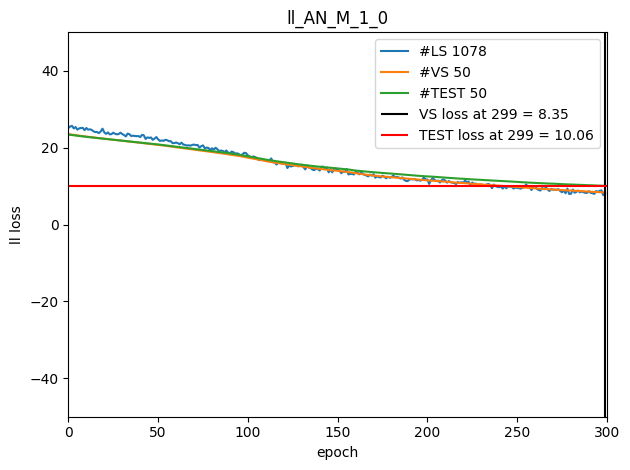

In [7]:
from GEFcom2014.models.NFs import fit_NF
from torch.utils.benchmark import timer
from GEFcom2014.utils import dump_file

print('Fit NFs with %s epochs' % (nb_epoch))
training_time = 0.
start = timer()
loss, best_flow, last_flow = fit_NF(nb_epoch=nb_epoch, x_LS=x_LS_scaled, y_LS=y_LS_scaled, x_VS=x_VS_scaled,
                                    y_VS=y_VS_scaled, x_TEST=x_TEST_scaled, y_TEST=y_TEST_scaled,
                                    flow=nfs,
                                    opt=opt, gpu=gpu)

end = timer()
training_time += end - start
print('Training time %.2f s' % (training_time))
epoch_min = np.nanargmin(loss[:, 1])
print('epoch %s ll VS is min = %.2f ll TEST = %.2f' % (epoch_min, loss[epoch_min, 1], loss[epoch_min, 2]))

dump_file(dir=dir_path, name='loss_' + name, file=loss)
dump_file(dir=dir_path, name='model_' + name + '_best', file=best_flow)
dump_file(dir=dir_path, name='model_' + name + '_last', file=last_flow)

plot_loss(loss=loss, nb_days=[nb_days_LS, nb_days_VS, nb_days_TEST], ylim=ylim_loss, dir_path=dir_path, name='ll_' + name)

### Build scenarios on VS & TEST

In [8]:
from GEFcom2014.models.NFs import build_nfs_scenarios

# load flow model from file:
# best_flow = read_file(dir=dir_path, name=name)

max_power = 1

# Scenarios are generated into a dict of length nb days (#VS or # TEST sizes)
# Each day of the dict is an array of shape (n_scenarios, 24)

generation_time = 0.
start = timer()
s_TEST = build_nfs_scenarios(n_s=n_s, x=x_TEST_scaled,
                              y_scaler=y_LS_scaler, flow=best_flow,
                              conditioner_args=config['conditioner_args'], max=max_power, gpu=gpu, non_null_indexes=non_null_indexes, samples_per_day=samples_per_day)
s_VS = build_nfs_scenarios(n_s=n_s, x=x_VS_scaled,
                            y_scaler=y_LS_scaler, flow=best_flow,
                            conditioner_args=config['conditioner_args'], max=max_power, gpu=gpu, non_null_indexes=non_null_indexes, samples_per_day=samples_per_day)
end = timer()
generation_time += end - start
print('Generation time (LS, VS, TEST) %.2f s' % (generation_time))
# Export the NF scenarios
# dict of nb_days with an array per day of shape = (nb_scenarios, 24)
dump_file(dir=dir_path, name='scenarios_' + name + '_' + str(n_s) + '_TEST', file=s_TEST)
dump_file(dir=dir_path, name='scenarios_' + name + '_' + str(n_s) + '_VS', file=s_VS)

3 6
Scenario generation time_tot 0.0 min
3 6
Scenario generation time_tot 0.0 min
Generation time (LS, VS, TEST) 1.53 s


### Evaluate

PLF TEST 1.9612 VS 1.8337



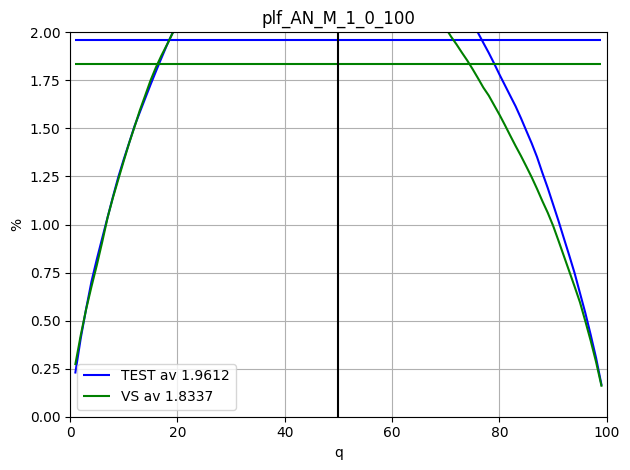

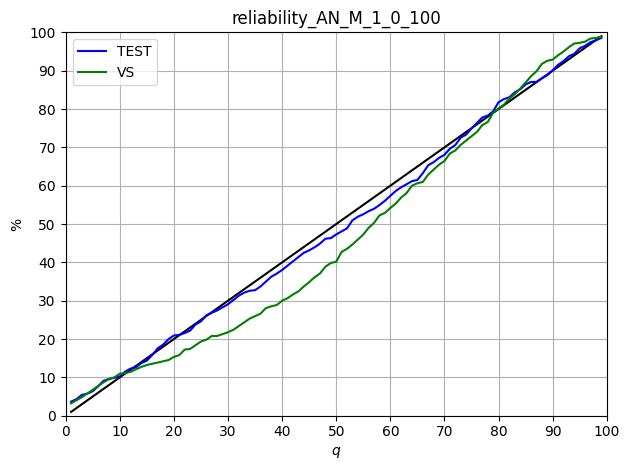

MAE TEST 1.35 VS 4.70
RMSE TEST 1.64 VS 5.70



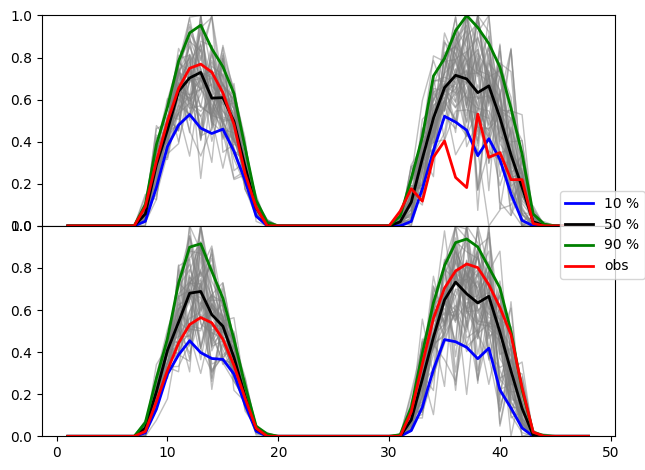

CRPS TEST 3.88 VS 3.63



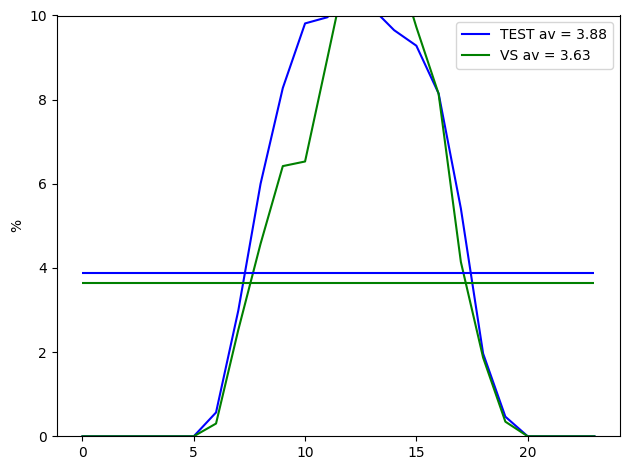

In [9]:
from GEFcom2014.forecast_quality import quantiles_and_evaluation

quantiles_and_evaluation(dir_path=dir_path, s_VS=s_VS, s_TEST=s_TEST, N_q=N_q, df_y_VS=df_y_VS, df_y_TEST=df_y_TEST,
                         name=name, ymax_plf=ymax_plf, ylim_crps=ylim_crps, nb_zones=nb_zones)

## Manual experiments with Testing data

In [10]:
from torch.utils.benchmark import timer
from GEFcom2014.utils import read_file

# load flow model from file:
best_flow = read_file(dir="/content/dgm-2023.2/projetos/PVGEN/src/export/multi_nfs/", name="model_AN_M_1_0_best")

In [11]:
n_s = 100
x = x_TEST_scaled
y_scaler = y_LS_scaler
flow = best_flow
conditioner_args = config['conditioner_args']
max = 1
gpu = True
#non_null_indexes
samples_per_day  =24

In [12]:
"""
Build scenarios for a NFs multi-output.
Scenarios are generated into an array (n_periods, n_s) where n_periods = 24 * n_days
:return: scenarios (n_periods, n_s)
"""
# to assign the data to GPU with .to(device) on the data
if gpu:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = "cpu"
flow.to(device)

n_periods_before = non_null_indexes[0]
n_periods_after = samples_per_day - non_null_indexes[-1] - 1
print(n_periods_after, n_periods_before)

n_days = len(x)
nb_output, cond_in = conditioner_args['in_size'], conditioner_args['cond_in']
time_tot = 0.
scenarios = []
for i in range(n_days):
    start = timer()
    # sample nb_scenarios per day
    predictions = flow.invert(z=torch.randn(n_s, nb_output).to(device), context=torch.tensor(np.tile(x[i, :], n_s).reshape(n_s, cond_in)).to(device).float()).cpu().detach().numpy()
    predictions = y_scaler.inverse_transform(predictions)

    # corrections -> genereration is always > 0 and < max capacity
    predictions[predictions < 0] = 0
    predictions[predictions > max] = max
    # fill time period where PV is not 0 are given by non_null_indexes
    # for instance it could be [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
    # then it is needed to add 0 for periods [0, 1, 2, 3] and [20, 21, 22, 23]

    scenarios_tmp = np.concatenate((np.zeros((predictions.shape[0], n_periods_before)), predictions, np.zeros((predictions.shape[0], n_periods_after))), axis=1)  # shape = (n_s, 24)
    scenarios.append(scenarios_tmp.transpose()) # list of arrays of shape (24, n_s)
    end = timer()
    time_tot += end - start
    print("day {:.0f} Approximate time left : {:2f} min".format(i, time_tot / (i + 1) * (n_days - (i + 1))/60), end="\r",flush=True)
    # if i % 20 == 0:
    #     print("day {:.0f} Approximate time left : {:2f} min".format(i, time_tot / (i + 1) * (nb_days - (i + 1)) / 60))
print('Scenario generation time_tot %.1f min' % (time_tot / 60))
returned = np.concatenate(scenarios,axis=0) # shape = (24*n_days, n_s)

# Calculate the average prediction for each hour
average_prediction = np.mean(returned, axis=1)

3 6
Scenario generation time_tot 0.0 min


In [13]:
import matplotlib.pyplot as plt

N = 10  # replace with the day number you're interested in

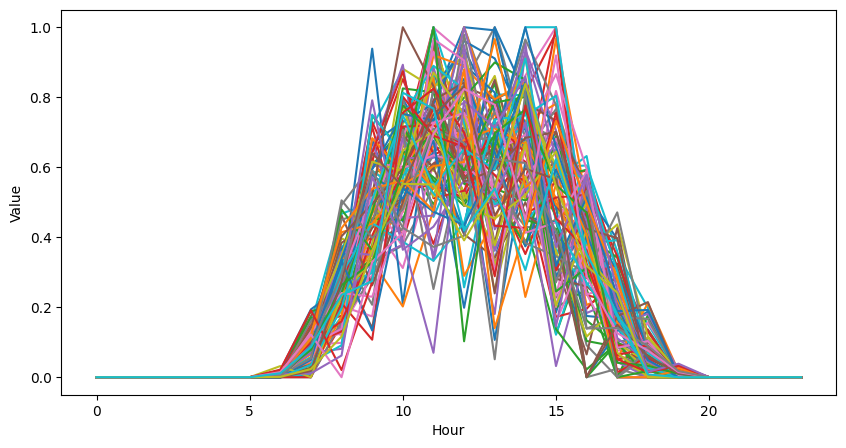

In [14]:
# Plot all predictions for the Nth day
plt.figure(figsize=(10,5))
for i in range(n_s):
    plt.plot(returned[(N-1)*24:(N*24), i])
plt.xlabel('Hour')
plt.ylabel('Value')
plt.show()

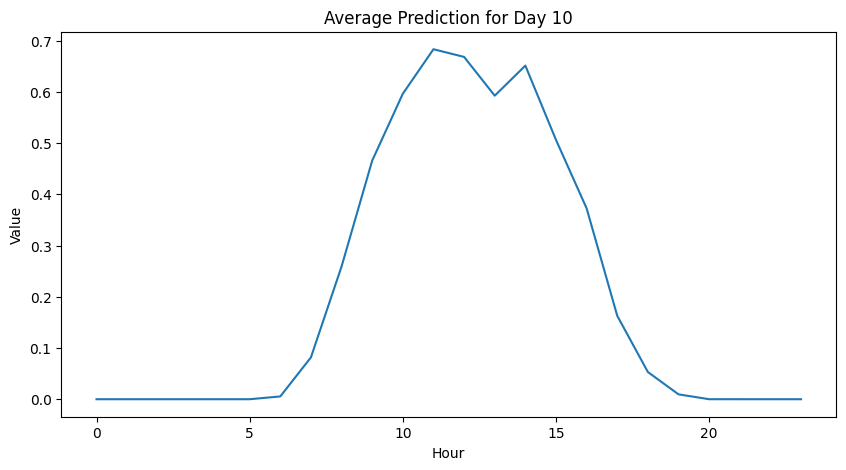

In [15]:
plt.figure(figsize=(10,5))
plt.plot(average_prediction[(N-1)*24:N*24])
plt.xlabel('Hour')
plt.ylabel('Value')
plt.title('Average Prediction for Day {}'.format(N))
plt.show()

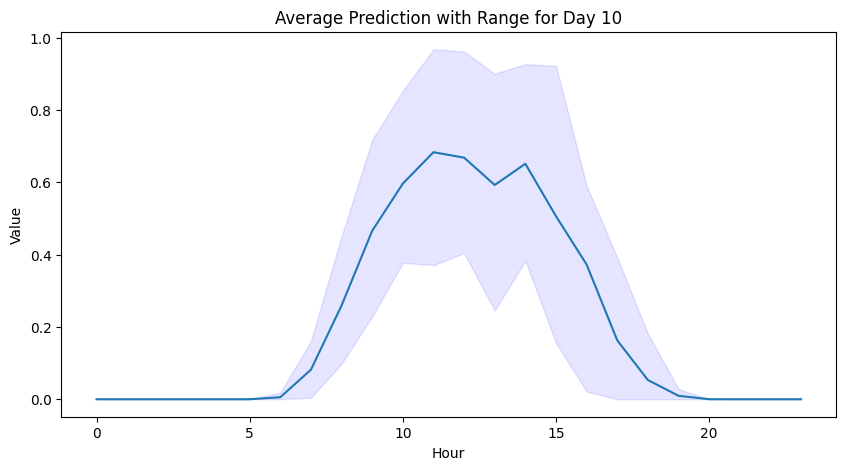

In [16]:
# Calculate percentiles
lower_bound = np.percentile(returned, 5, axis=1)
upper_bound = np.percentile(returned, 95, axis=1)

# Plot average prediction with range for the Nth day
plt.figure(figsize=(10,5))
plt.plot(average_prediction[(N-1)*24:N*24])
plt.fill_between(range(24), lower_bound[(N-1)*24:N*24], upper_bound[(N-1)*24:N*24], color='b', alpha=.1)
plt.xlabel('Hour')
plt.ylabel('Value')
plt.title('Average Prediction with Range for Day {}'.format(N))
plt.show()

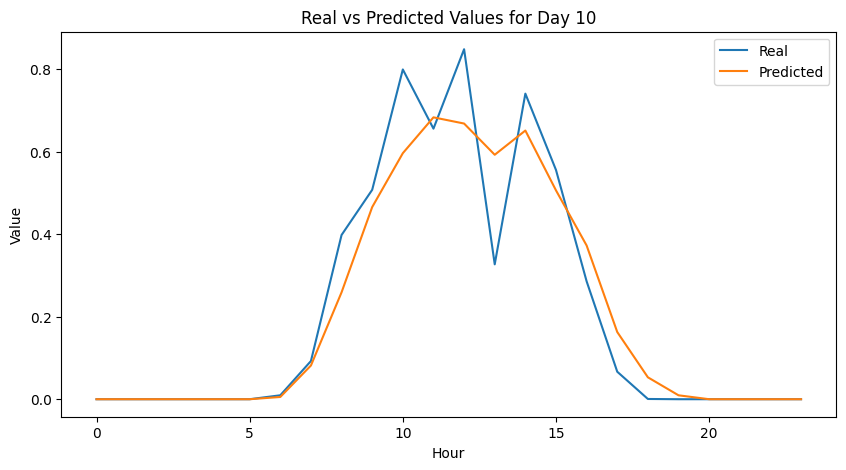

In [18]:
# Plot real values
plt.figure(figsize=(10,5))
plt.plot(df_y_TEST.iloc[N-1].values, label='Real')

# Plot average prediction
plt.plot(average_prediction[(N-1)*24:N*24], label='Predicted')

plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend()
plt.title('Real vs Predicted Values for Day {}'.format(N))
plt.show()

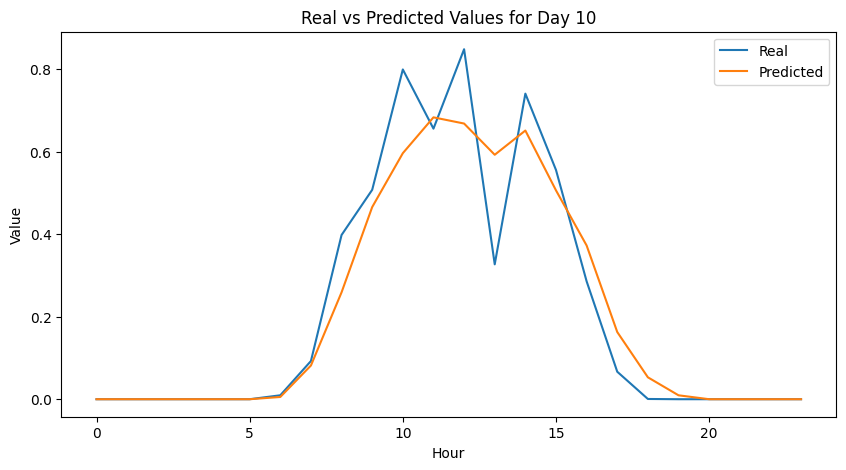

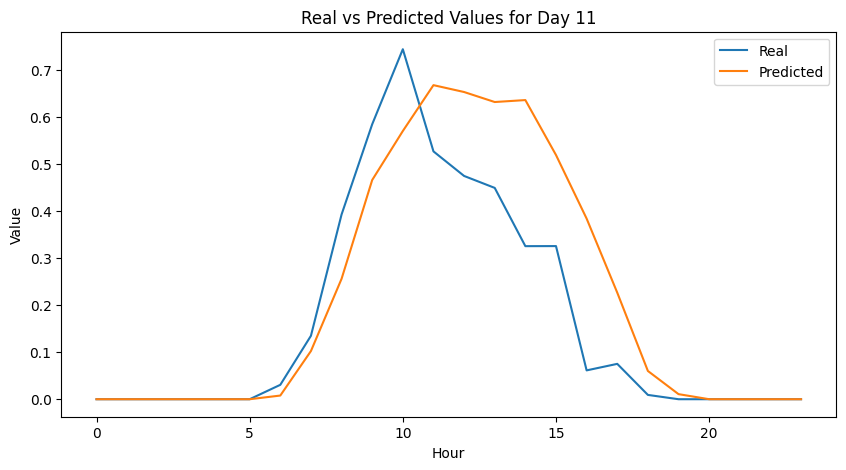

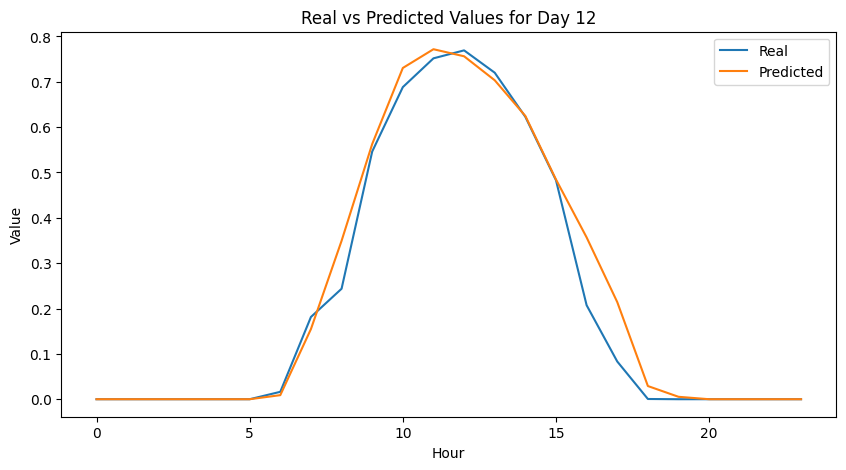

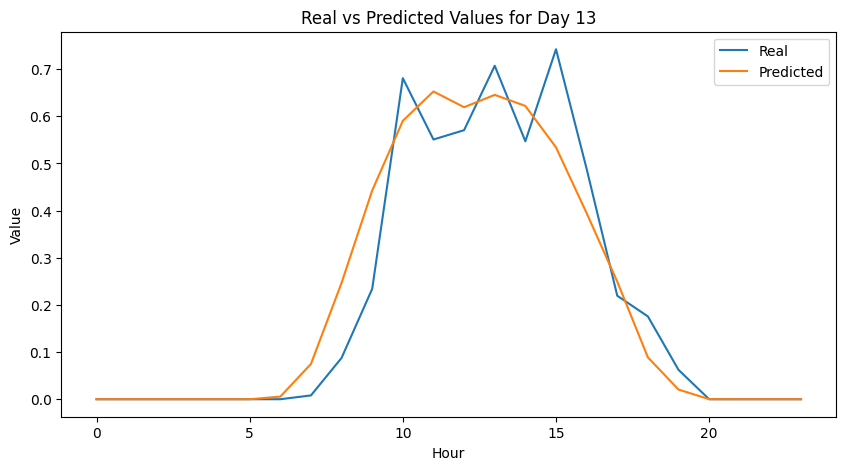

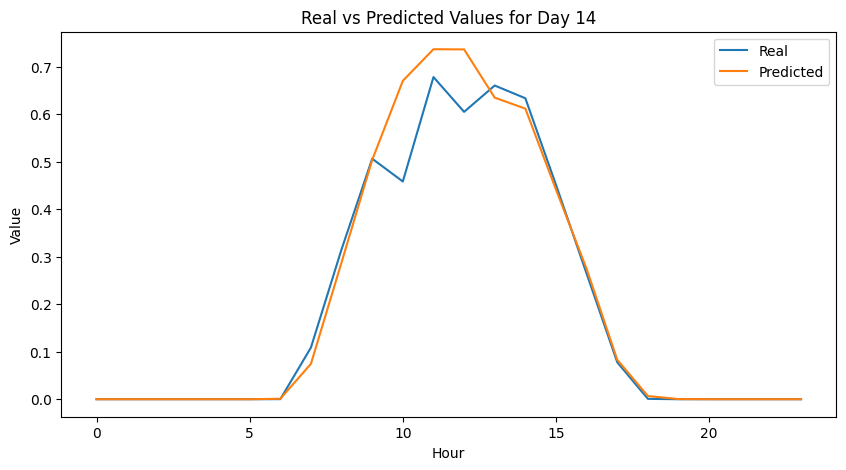

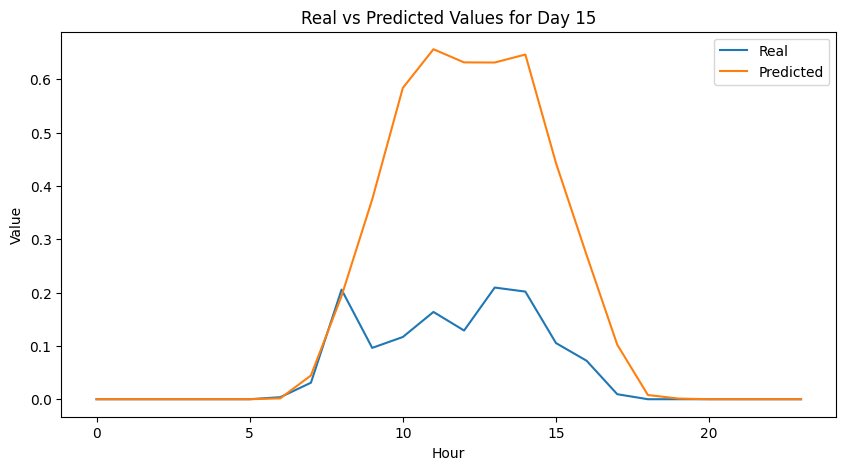

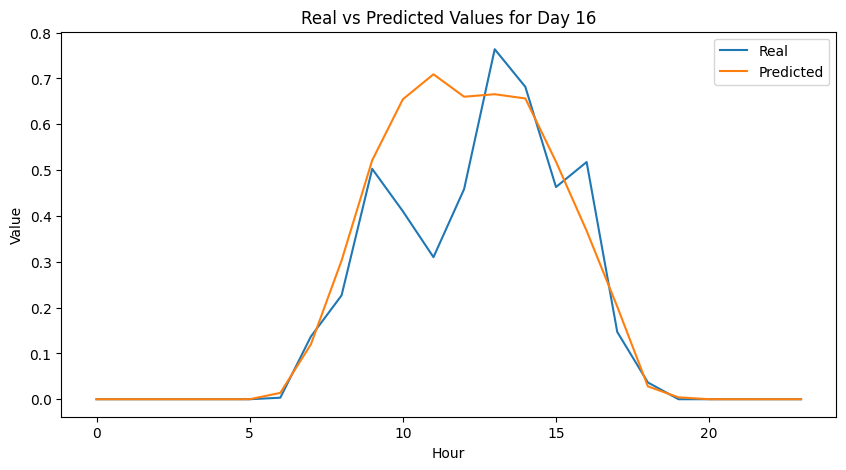

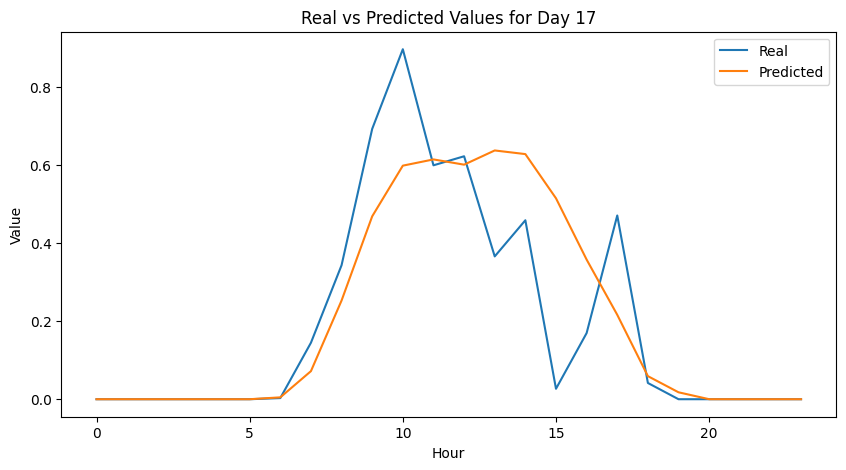

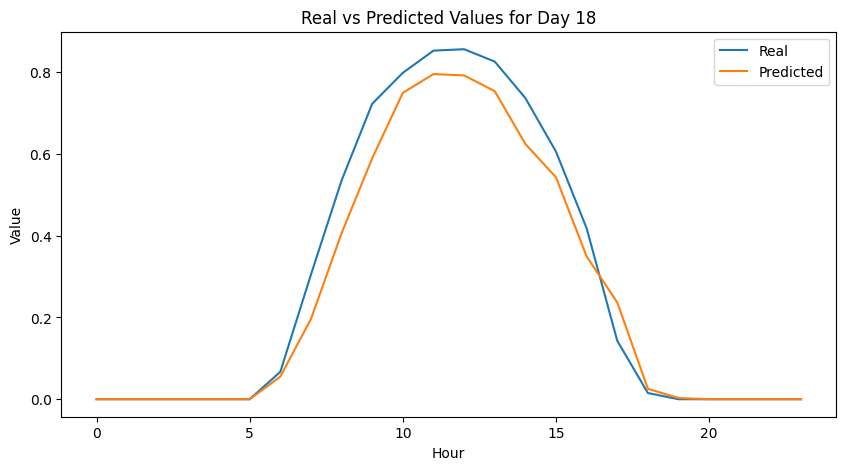

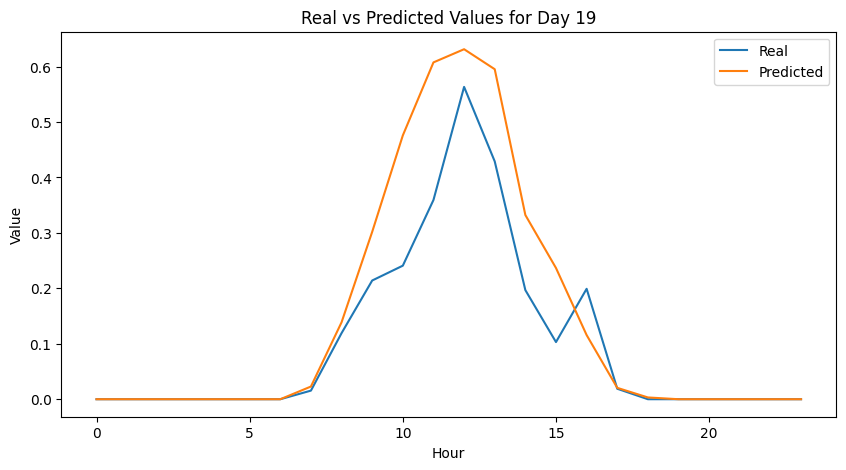

In [19]:
# Plot for a range of days

min_range = 10
max_range = 20
# Calculate the average prediction for each hour
average_prediction = np.mean(returned, axis=1)

for N in range(min_range, max_range):
    # Plot real values
    plt.figure(figsize=(10,5))
    plt.plot(df_y_TEST.iloc[N-1].values, label='Real')

    # Plot average prediction
    plt.plot(average_prediction[(N-1)*24:N*24], label='Predicted')

    plt.xlabel('Hour')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Real vs Predicted Values for Day {}'.format(N))
    plt.show()